# class images

In [ ]:
import os
import pandas as pd
import shutil

mapping_csv = 'csvs\merged_final.csv'      
images_folder = 'images'        
output_folder = 'class_images'                 
new_mapping_csv = 'image_class_mapping.csv'    

os.makedirs(output_folder, exist_ok=True)

df = pd.read_csv(mapping_csv)
df['asset_id'] = df['asset_id'].astype(str)

output_rows = []

for class_name, group in df.groupby('class'):
    class_dir = os.path.join(output_folder, class_name)
    os.makedirs(class_dir, exist_ok=True)

    selected = group.sample(n=min(1000, len(group)), random_state=42)

    for _, row in selected.iterrows():
        asset_id = row['asset_id']
        image_found = False

        for ext in ['.jpg', '.jpeg', '.png']:
            image_name = asset_id + ext
            image_path = os.path.join(images_folder, image_name)

            if os.path.exists(image_path):
                shutil.copy(image_path, os.path.join(class_dir, image_name))
                output_rows.append({'image_name': image_name, 'class': class_name})
                image_found = True
                break

        if not image_found:
            print(f"⚠ Image not found for Asset ID: {asset_id}")

pd.DataFrame(output_rows).to_csv(new_mapping_csv, index=False)
print(f"\n✅ Completed. Saved {len(output_rows)} images to {output_folder} and mapping to {new_mapping_csv}")


⚠ Image not found for Asset ID: 287247
⚠ Image not found for Asset ID: 282534

✅ Completed. Saved 9998 images to class_images and mapping to image_class_mapping.csv


# preprocessing

Processing class_images\Barred Spiral\172286.jpg
Processing class_images\Barred Spiral\99277.jpg
Processing class_images\Barred Spiral\16393.jpg
Processing class_images\Barred Spiral\137501.jpg
Processing class_images\Barred Spiral\258488.jpg
Processing class_images\Barred Spiral\233459.jpg
Processing class_images\Barred Spiral\63508.jpg
Processing class_images\Barred Spiral\94507.jpg
Processing class_images\Barred Spiral\30224.jpg
Processing class_images\Barred Spiral\271482.jpg
Processing class_images\Barred Spiral\127399.jpg
Processing class_images\Barred Spiral\82240.jpg
Processing class_images\Barred Spiral\237071.jpg
Processing class_images\Barred Spiral\83397.jpg
Processing class_images\Barred Spiral\122508.jpg
Processing class_images\Barred Spiral\152983.jpg
Processing class_images\Barred Spiral\787.jpg
Processing class_images\Barred Spiral\35450.jpg
Processing class_images\Barred Spiral\273141.jpg
Processing class_images\Barred Spiral\169265.jpg
Processing class_images\Barred 

C:\Users\Hp\AppData\Local\Temp\ipykernel_20312\1908552805.py:92: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  axs[i, 2].hist(imgs['gray'].ravel(), 256, [0, 256])


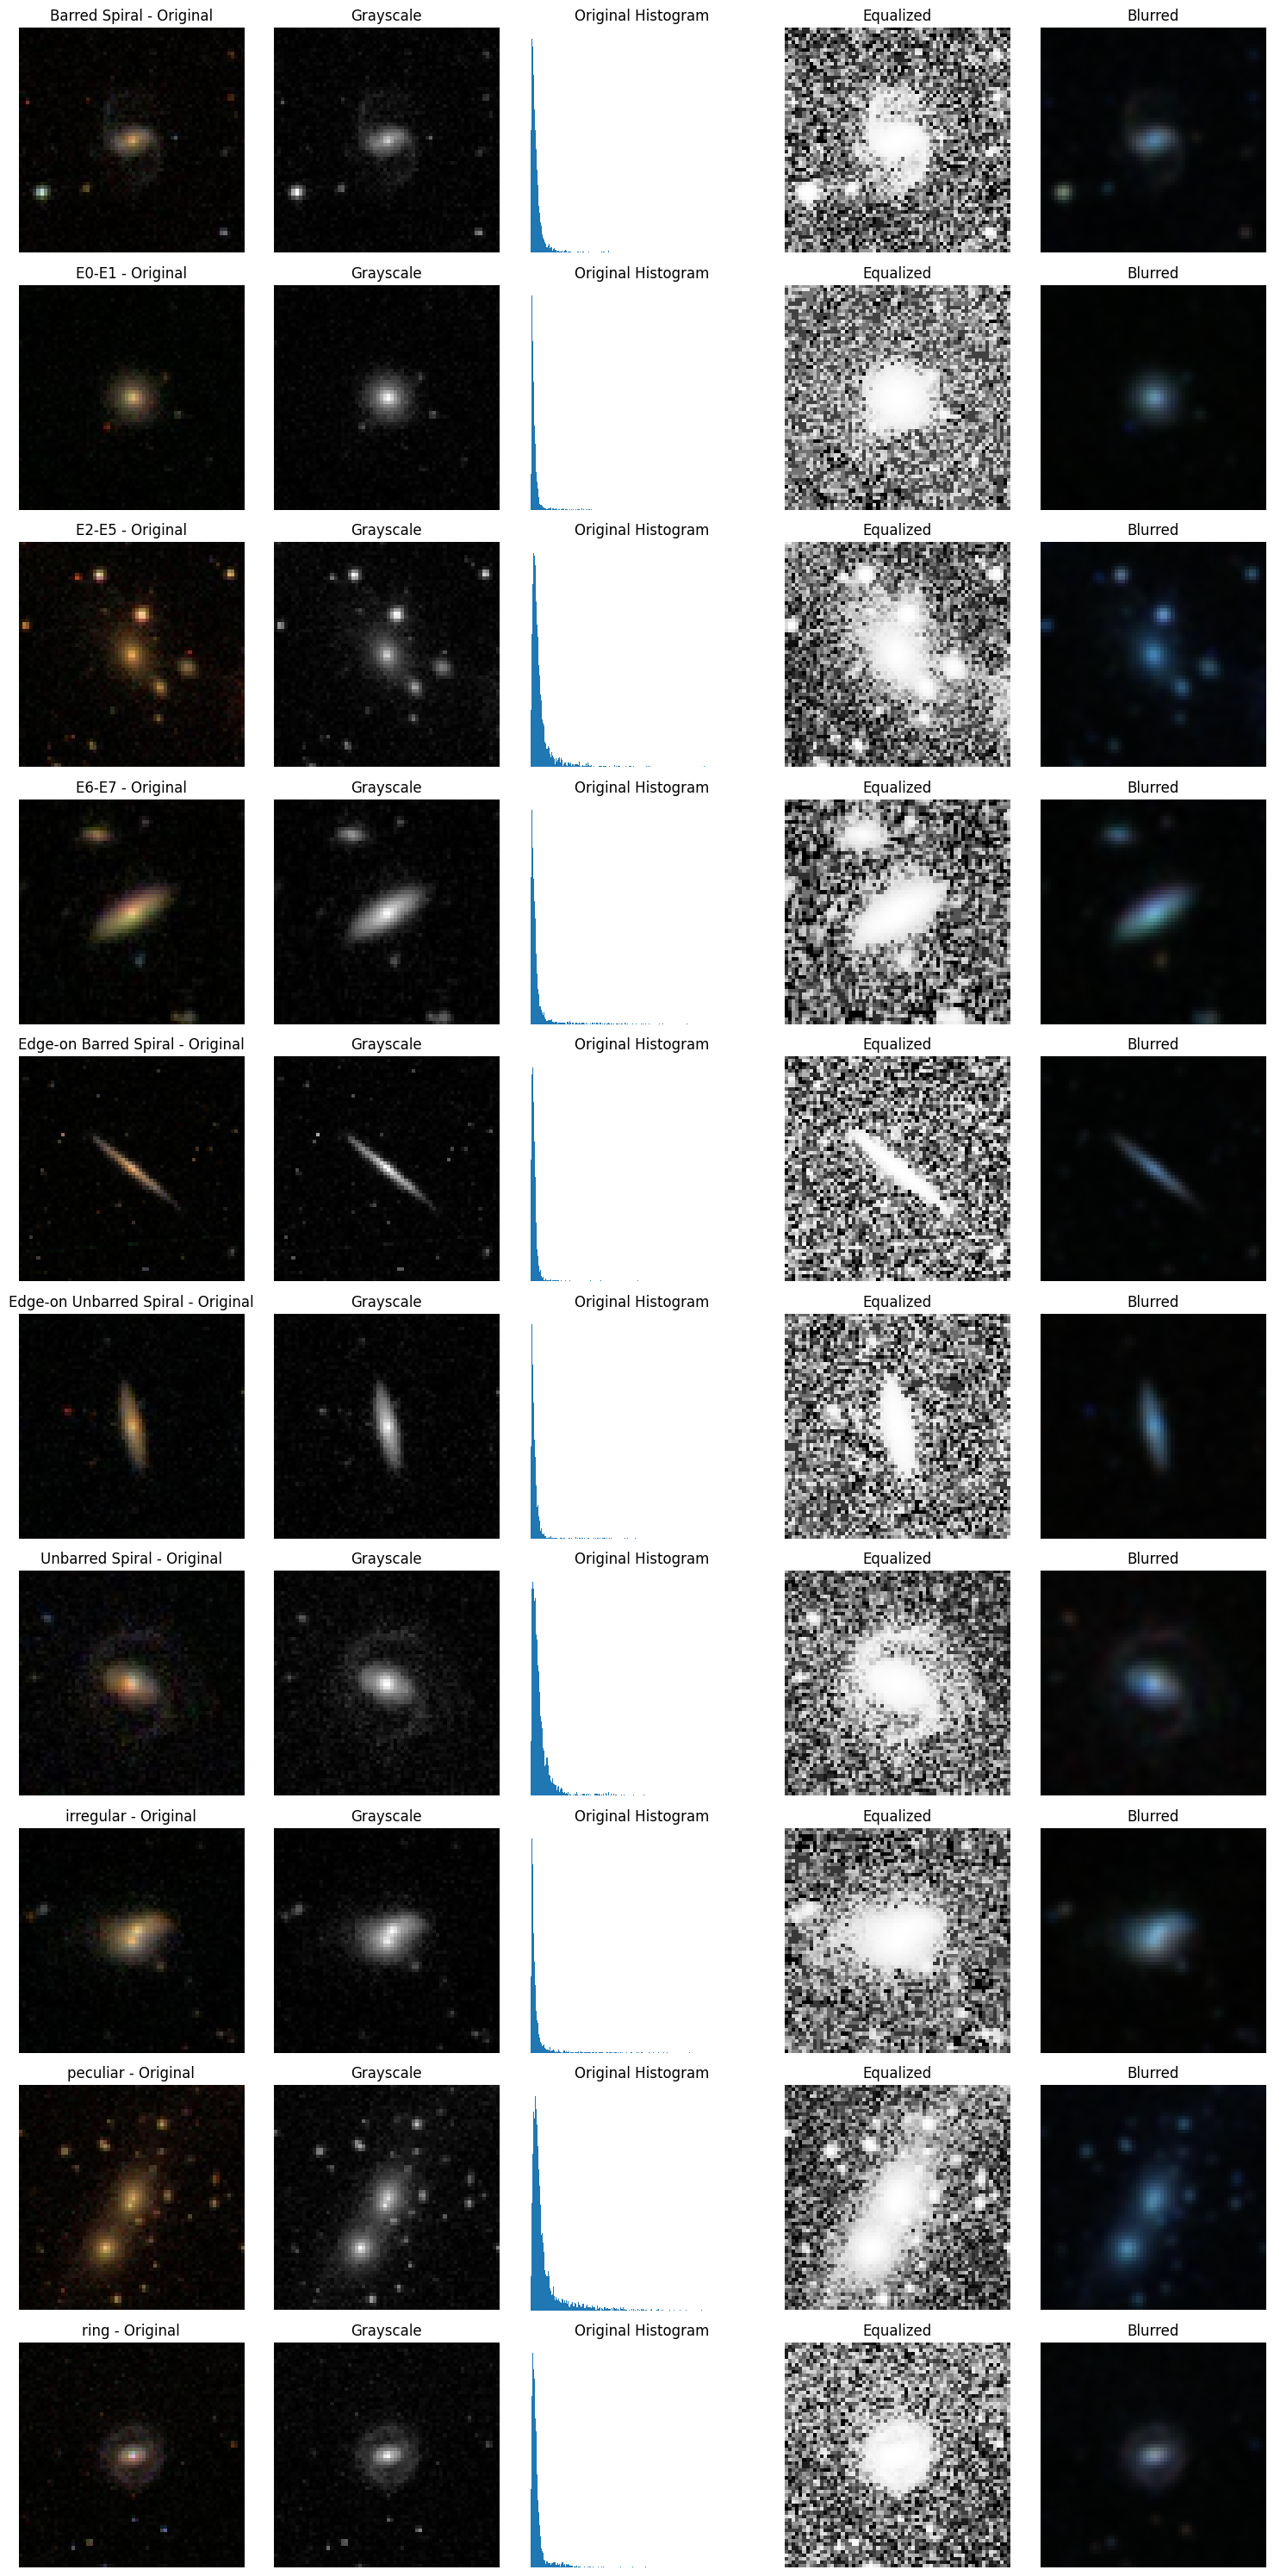

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_csv = "image_class_mapping.csv"  
input_dir = "class_images"            
output_dir = "preprocessed_class_images"
updated_csv = "updated_dataset.csv"

new_asset_id_start = 300000

os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(input_csv)
new_entries = []

examples = {}

new_id = new_asset_id_start
for idx, row in df.iterrows():
    asset_id, class_name = row['image_name'], row['class']
    asset_id_without_extension = os.path.splitext(asset_id)[0]
    input_path = os.path.join(input_dir, class_name, f"{asset_id_without_extension}.jpg")

    if not os.path.exists(input_path):
        print(f"Image {asset_id}.jpg for class {class_name} is missing. Skipping...")
        continue
    else:
        print(f"Processing {input_path}")

    img = cv2.imread(input_path)
    resized_img = cv2.resize(img, (64, 64))

    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    hist_eq = cv2.equalizeHist(gray)

    _, bg_removed = cv2.threshold(hist_eq, 30, 255, cv2.THRESH_TOZERO)

    blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)

    new_img_name = f"{new_id}.jpg"
    class_out_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_out_dir, exist_ok=True)

    cv2.imwrite(os.path.join(class_out_dir, f"blurred_{new_img_name}"), blurred_img)
    cv2.imwrite(os.path.join(class_out_dir, f"bg_removed_{new_img_name}"), bg_removed)

    new_entries.append({
        'asset_id': new_id,
        'class': class_name,
    })

    if class_name not in examples:
        examples[class_name] = {
            'original': resized_img,
            'gray': gray,
            'hist_eq': hist_eq,
            'bg_removed': bg_removed,
            'blurred': blurred_img
        }

    new_id += 1

updated_df = pd.DataFrame(new_entries)
updated_df.to_csv(updated_csv, index=False)

fig, axs = plt.subplots(len(examples), 5, figsize=(15, 3 * len(examples)))
for i, (cls, imgs) in enumerate(examples.items()):
    axs[i, 0].imshow(cv2.cvtColor(imgs['original'], cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"{cls} - Original")

    axs[i, 1].imshow(imgs['gray'], cmap='gray')
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].hist(imgs['gray'].ravel(), 256, [0, 256])
    axs[i, 2].set_title("Original Histogram")

    axs[i, 3].imshow(imgs['hist_eq'], cmap='gray')
    axs[i, 3].set_title("Equalized")

    axs[i, 4].imshow(imgs['blurred'], cmap='gray')
    axs[i, 4].set_title("Blurred")

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()



---

## 1. `cv2.imread(filename)`
- **Purpose**: Load an image from your computer into your program.
- **Parameters**:
  - `filename`: The path to the image file (e.g., "cat.jpg").
- **How it works**:
  This function opens the image file and stores its pixel data in memory.
  The image is stored as a 3D NumPy array in BGR format (Blue, Green, Red).

---

## 2. `cv2.resize(src, dsize)`
- **Purpose**: Change the size (dimensions) of an image.
- **Parameters**:
  - `src`: The image you want to resize.
  - `dsize`: A tuple like `(64, 64)` representing the new width and height.
- **How it works**:
  It scales the image up or down to the size you want by calculating and placing new pixel values.

---

## 3. `cv2.cvtColor(src, code)`
- **Purpose**: Convert the image from one color format to another.
- **Parameters**:
  - `src`: The original image.
  - `code`: The type of conversion (e.g., `cv2.COLOR_BGR2GRAY` to make it black and white).
- **How it works**:
  It changes how color is represented — for example, turning a color image into a grayscale one by calculating brightness values from color.

---

## 4. `cv2.equalizeHist(src)`
- **Purpose**: Improve the contrast of a grayscale image.
- **Parameters**:
  - `src`: A grayscale image (black and white).
- **How it works**:
  It spreads out the brightness values more evenly.
  This makes dark areas lighter and bright areas darker, helping details stand out.

---

## 5. `cv2.threshold(src, thresh, maxval, type)`
- **Purpose**: Remove the background or isolate parts of the image.
- **Parameters**:
  - `src`: Grayscale image.
  - `thresh`: The threshold value (e.g., `30`).
  - `maxval`: The value to assign to pixels that pass the threshold (e.g., `255`).
  - `type`: The thresholding method (e.g., `cv2.THRESH_TOZERO`).
- **How it works**:
  It checks each pixel:
  - If it’s lower than 30, set it to 0 (black).
  - If it’s higher, keep it as it is.
  This helps remove dark background pixels.

---

## 6. `cv2.GaussianBlur(src, ksize, sigmaX)`
- **Purpose**: Smooth the image to reduce noise or grain.
- **Parameters**:
  - `src`: The original image.
  - `ksize`: Size of the blur window (like `(5, 5)`).
  - `sigmaX`: The amount of blur in the X direction.
- **How it works**:
  It blends pixels with nearby ones using a special weighted average.
  This makes edges softer and removes small unwanted details.

---

## 7. `cv2.imwrite(filename, img)`
- **Purpose**: Save an image to your computer.
- **Parameters**:
  - `filename`: File name or path to save the image.
  - `img`: The image data to be saved.
- **How it works**:
  It takes the final image and writes it as a file (like saving a photo in Paint or Photoshop).

---


# Augmentation

Augmentation complete. CSV saved as: augmented_dataset.csv


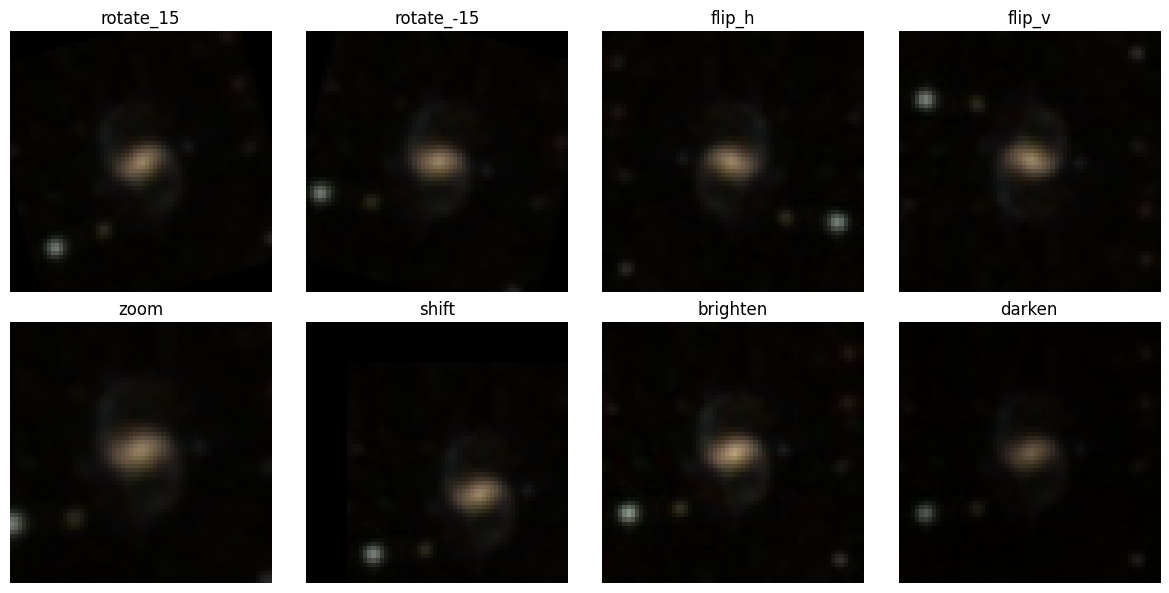

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_csv = "updated_dataset.csv"
input_dir = "preprocessed_class_images"
output_csv = "augmented_dataset.csv"

df = pd.read_csv(input_csv)
new_id = df['asset_id'].max() + 1
augmented_entries = []

def rotate(img, angle):
    h, w = img.shape[:2]
    matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    return cv2.warpAffine(img, matrix, (w, h))

def flip(img, mode):
    return cv2.flip(img, mode)

def zoom(img, scale=1.2):
    h, w = img.shape[:2]
    center = (int(w / 2), int(h / 2))
    new_w, new_h = int(w / scale), int(h / scale)
    x1 = center[0] - new_w // 2
    y1 = center[1] - new_h // 2
    cropped = img[y1:y1+new_h, x1:x1+new_w]
    return cv2.resize(cropped, (w, h))

def shift(img, x_shift, y_shift):
    matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))

def adjust_brightness(img, factor):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] *= factor
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

augmentations = [
    ("rotate_15", lambda img: rotate(img, 15)),
    ("rotate_-15", lambda img: rotate(img, -15)),
    ("flip_h", lambda img: flip(img, 1)),
    ("flip_v", lambda img: flip(img, 0)),
    ("zoom", lambda img: zoom(img, 1.2)),
    ("shift", lambda img: shift(img, x_shift=10, y_shift=10)),
    ("brighten", lambda img: adjust_brightness(img, 1.2)),
    ("darken", lambda img: adjust_brightness(img, 0.7))
]

grid_images = []

for idx, row in df.iterrows():
    class_name = row['class']
    base_name = f"{row['asset_id']}.jpg"
    class_path = os.path.join(input_dir, class_name)
    blurred_path = os.path.join(class_path, f"blurred_{base_name}")
    
    if not os.path.exists(blurred_path):
        print(f"Missing blurred image for asset {row['asset_id']}. Skipping...")
        continue

    blurred_img = cv2.imread(blurred_path)

    for suffix, aug_func in augmentations:
        aug_img = aug_func(blurred_img)
        aug_name = f"{new_id}.jpg"
        save_path = os.path.join(class_path, f"blurred_{aug_name}")
        cv2.imwrite(save_path, aug_img)

        augmented_entries.append({
            'asset_id': new_id,
            'class': class_name
        })

        if len(grid_images) < 8 and idx == 0:
            grid_images.append(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))

        new_id += 1

augmented_df = pd.concat([df, pd.DataFrame(augmented_entries)], ignore_index=True)
augmented_df.to_csv(output_csv, index=False)
print("Augmentation complete. CSV saved as:", output_csv)

if grid_images:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid_images[i])
        ax.axis('off')
        ax.set_title(augmentations[i][0])
    plt.tight_layout()
    plt.show()



---

## 1. `rotate(img, angle)`

**Parameters:**
- `img`: The input image to rotate.
- `angle`: Rotation angle in degrees. 
  - Positive = counterclockwise
  - Negative = clockwise

**How it Works:**
- Finds the center of the image.
- Creates a rotation matrix around the center using `cv2.getRotationMatrix2D()`.
- Uses `cv2.warpAffine()` to apply the rotation.
- Output is the same size as the original image, but the contents are rotated.

---

## 2. `flip(img, mode)`

**Parameters:**
- `img`: Input image.
- `mode`: Direction of flip.
  - `0` = Vertical (top ↔ bottom)
  - `1` = Horizontal (left ↔ right)
  - `-1` = Both directions

**How it Works:**
- `cv2.flip()` mirrors the image along the specified axis.
- Pixels are rearranged row-wise or column-wise depending on mode.

---

## 3. `zoom(img, scale=1.2)`

**Parameters:**
- `img`: Input image.
- `scale`: Zoom factor. >1 means zoom in.

**How it Works:**
- Crops a smaller area from the center of the image.
- Enlarges it back to the original size using `cv2.resize()`.
- Gives the effect of zooming into the center, cutting out outer edges.

---

## 4. `shift(img, x_shift, y_shift)`

**Parameters:**
- `img`: Input image.
- `x_shift`: Horizontal shift (pixels).
- `y_shift`: Vertical shift (pixels).

**How it Works:**
- Creates a transformation matrix for shifting.
- Uses `cv2.warpAffine()` to move pixels by the given shifts.
- Parts shifted out are filled with black by default.

---

## 5. `adjust_brightness(img, factor)`

**Parameters:**
- `img`: Input image.
- `factor`: Brightness adjustment.
  - >1 = Brighter
  - <1 = Darker

**How it Works:**
- Converts image from BGR to HSV using `cv2.cvtColor()`.
- HSV separates brightness (V channel) from color.
- Multiplies the V (value) channel by `factor` and clips values at 255.
- Converts image back to BGR format.

---

## 6. `cv2.warpAffine(img, matrix, (width, height))`

**Parameters:**
- `img`: The input image.
- `matrix`: 2x3 affine transformation matrix.
- `(width, height)`: Output image size.

**How it Works:**
- Applies the matrix transformation to the image.
- Used for rotation, translation (shift), etc.
- Maps pixels to new locations based on the matrix.

---

## 7. `cv2.resize(img, (width, height))`

**Parameters:**
- `img`: Input image.
- `(width, height)`: Desired size.

**How it Works:**
- Resizes the image to given dimensions.
- Useful for restoring original size after cropping/zooming.
- Maintains image content using interpolation.

---

## 8. `cv2.cvtColor(img, code)`

**Parameters:**
- `img`: Input image.
- `code`: Color space conversion code.

**How it Works:**
- Converts image between color spaces like BGR ↔ HSV.
- Used to isolate brightness (HSV) for tasks like brightness adjustment.

---



# advanced image processing

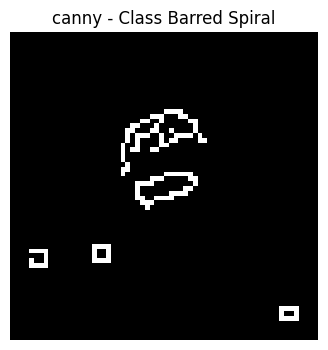

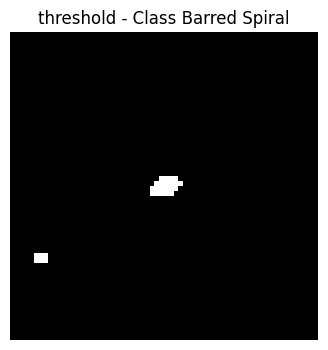

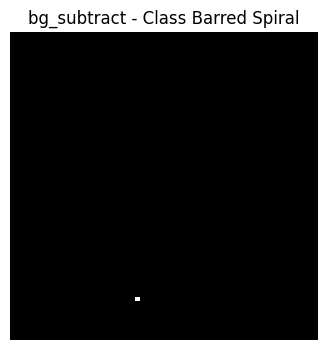

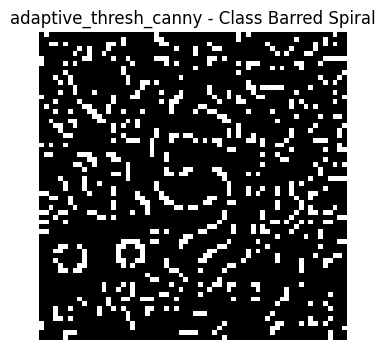

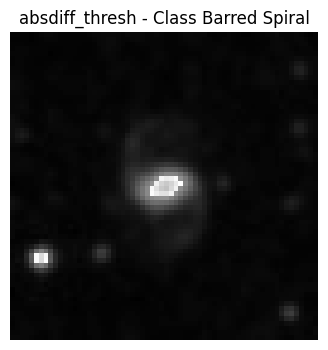

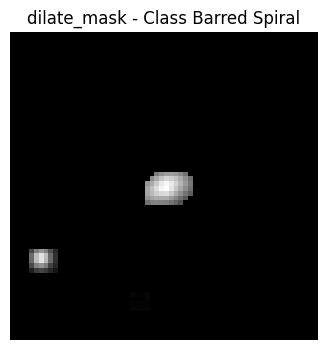

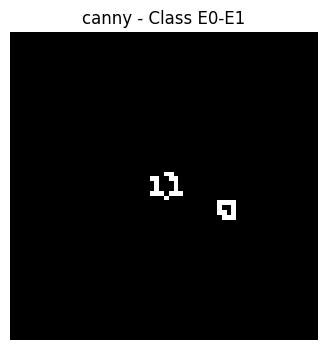

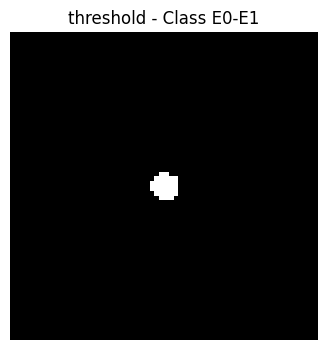

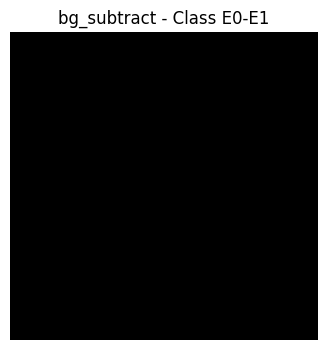

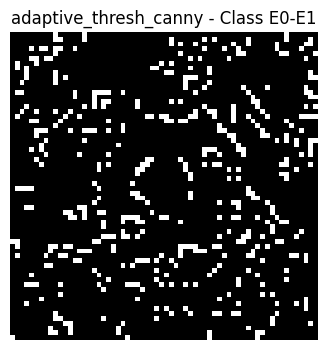

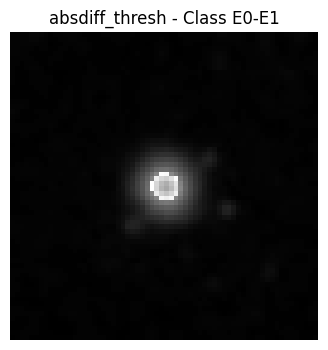

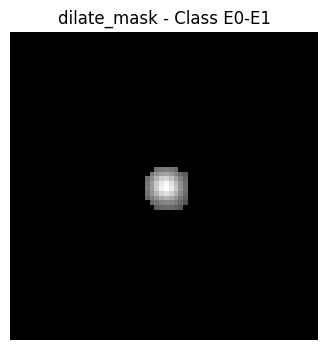

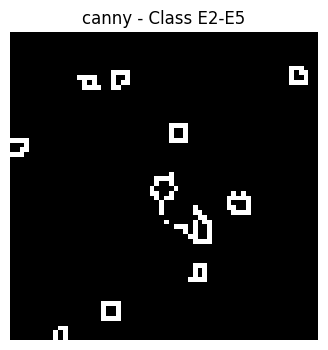

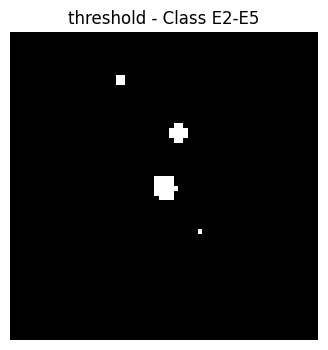

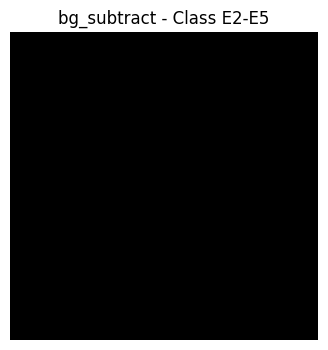

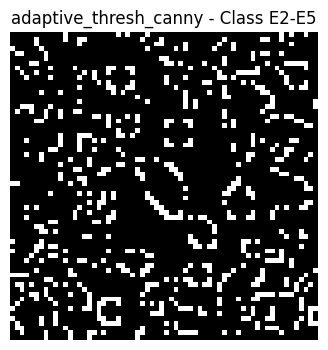

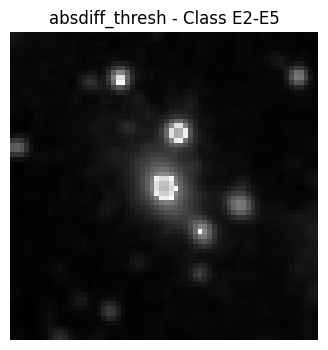

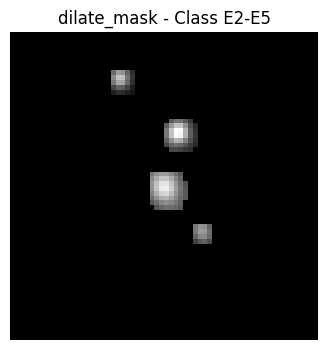

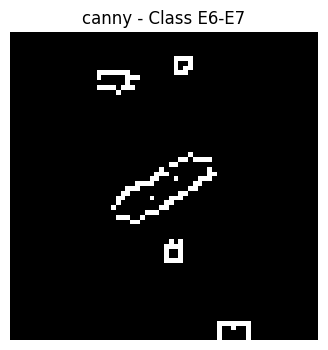

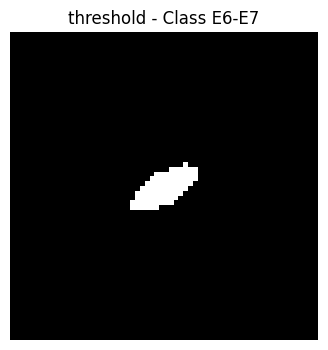

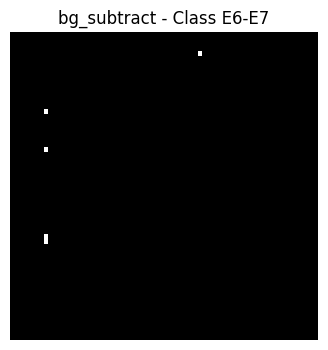

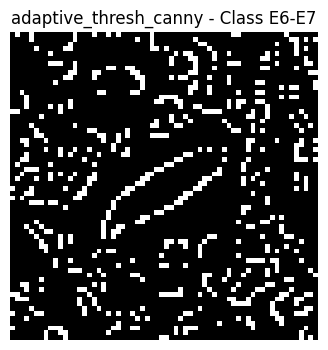

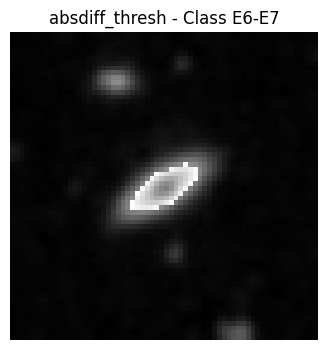

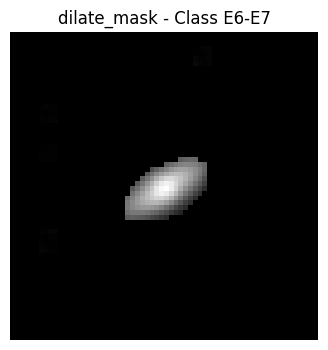

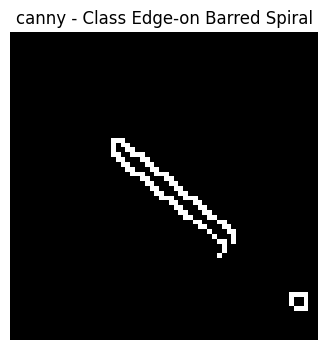

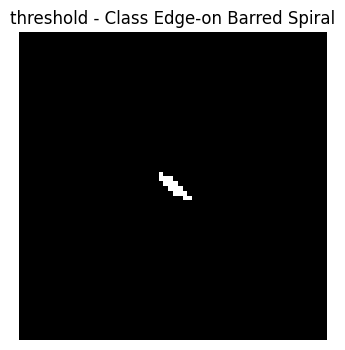

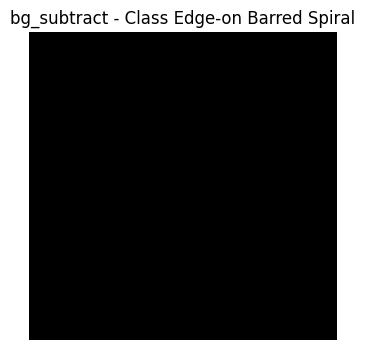

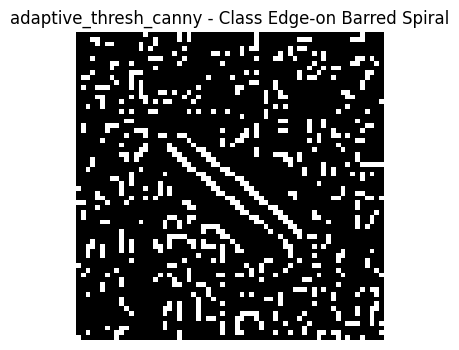

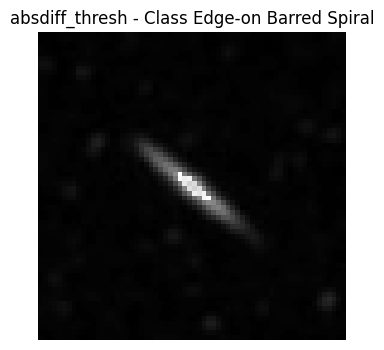

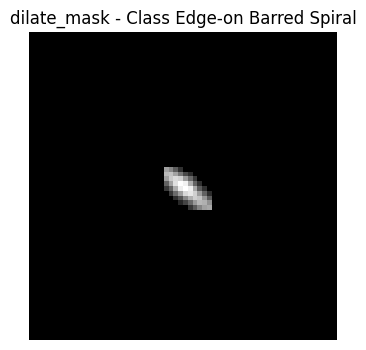

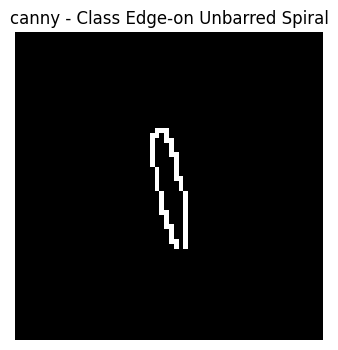

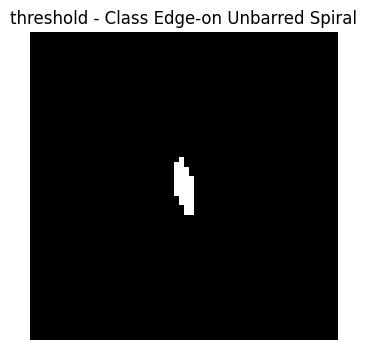

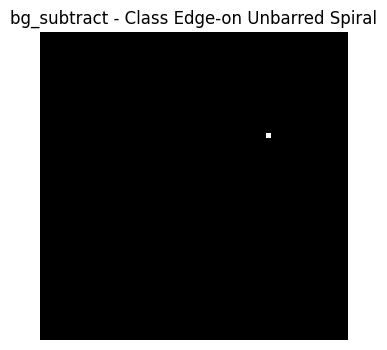

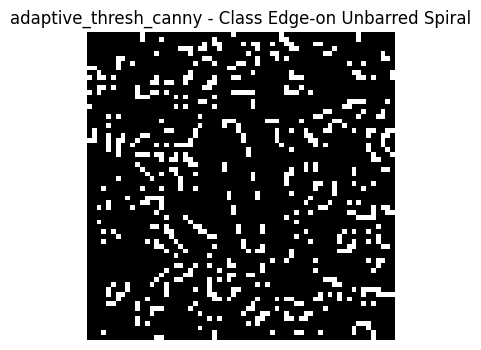

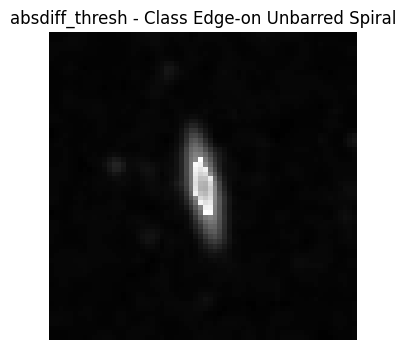

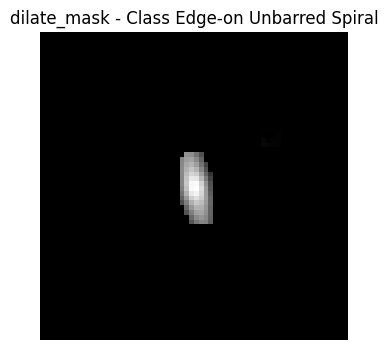

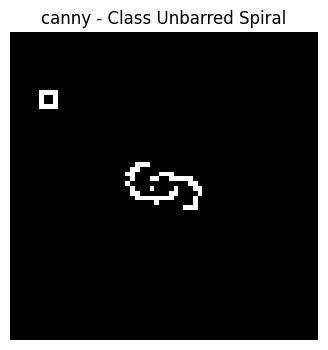

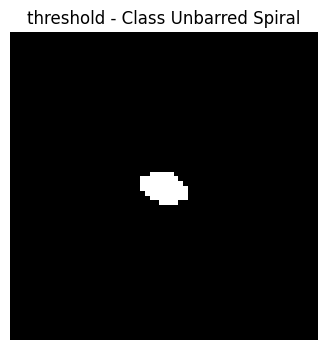

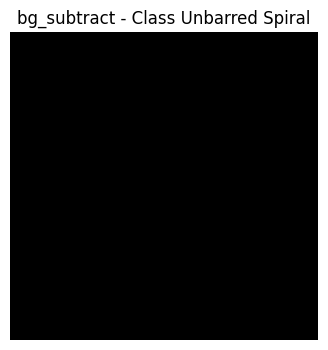

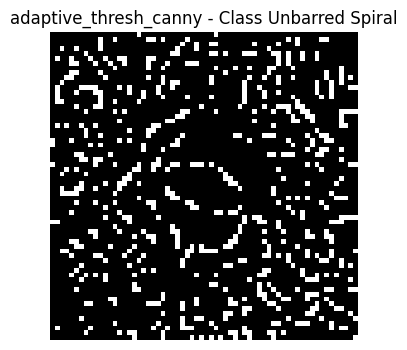

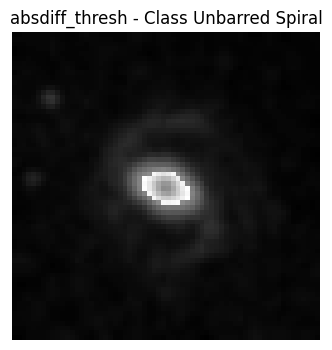

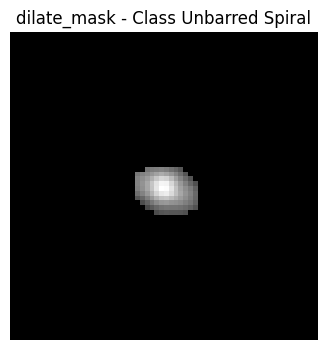

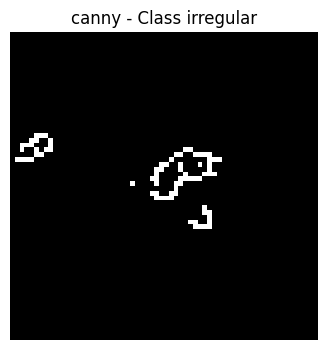

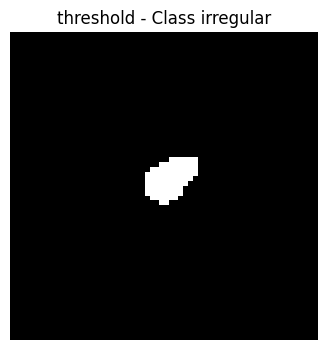

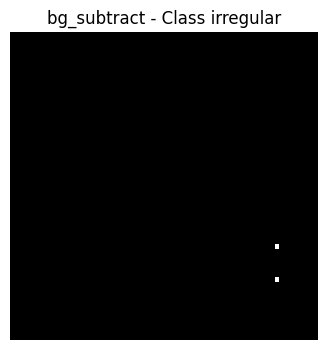

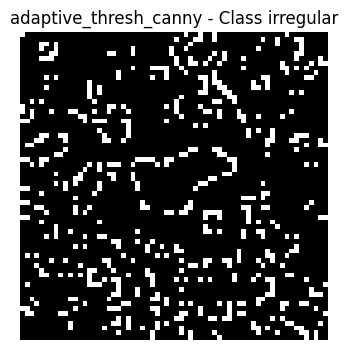

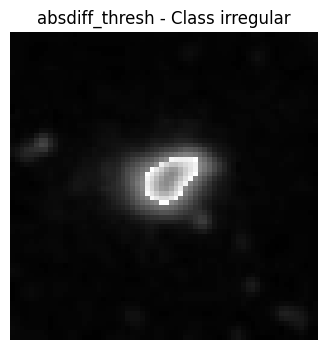

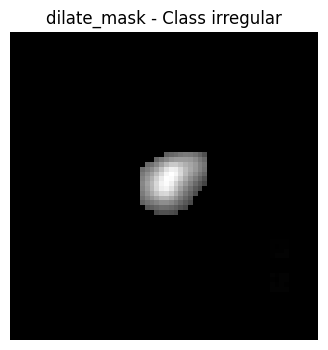

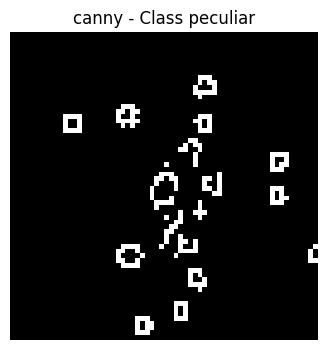

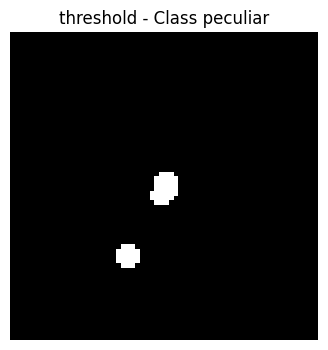

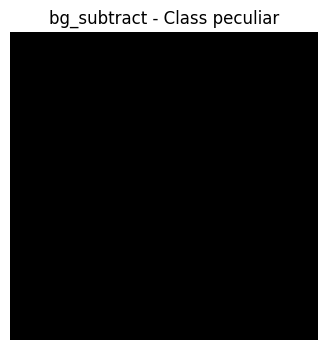

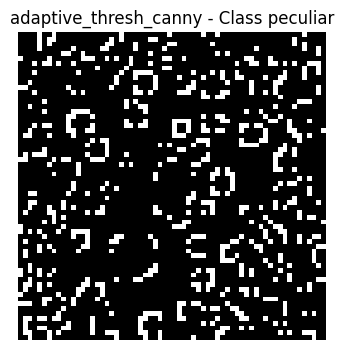

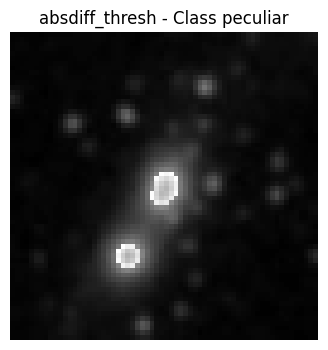

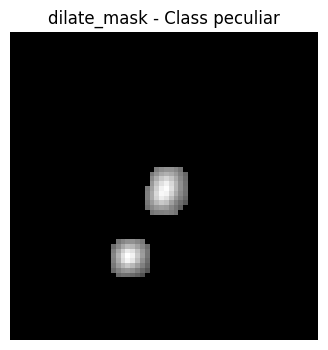

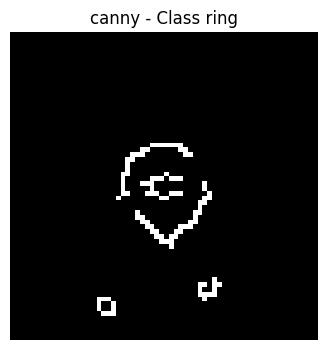

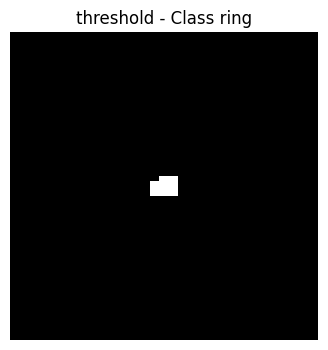

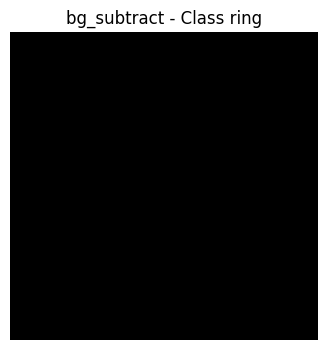

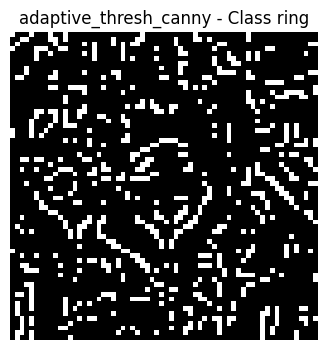

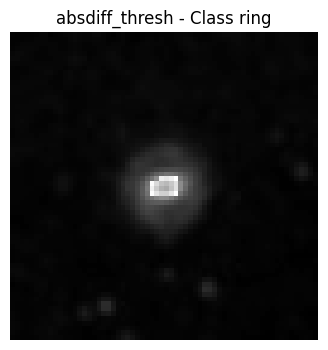

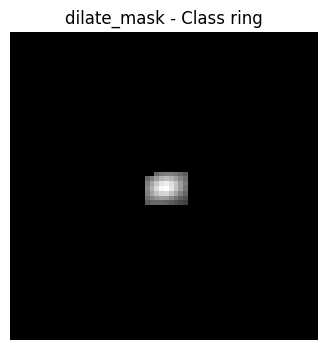

Done. Saved: transformed_dataset.csv


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_csv = "augmented_dataset.csv"
input_dir = "preprocessed_class_images"
output_csv = "transformed_dataset.csv"

df = pd.read_csv(input_csv)
augmented_entries = []
shown_classes = set()  
new_id = df['asset_id'].max() + 1

def canny(img):
    return cv2.Canny(img, 5, 80)

def threshold(img):
    _, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
    return thresh_img

def bg_subtract(img):
    back_sub = cv2.createBackgroundSubtractorMOG2()
    return back_sub.apply(img)

def adaptive_thresh_canny(img):
    a_thresh_img = cv2.adaptiveThreshold(img, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 1)
    return cv2.Canny(a_thresh_img, 1000, 1000)

def absdiff_thresh(img):
    _, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
    return cv2.absdiff(img, thresh_img)

def dilate_mask(img):
    _, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
    mask = cv2.inRange(img, img, thresh_img)
    kernel = np.ones((4, 4), dtype="uint8")
    dilated_img = cv2.dilate(mask, kernel)
    return cv2.bitwise_and(img, img, mask=dilated_img)

transformations = [
    ("canny", canny),
    ("threshold", threshold),
    ("bg_subtract", bg_subtract),
    ("adaptive_thresh_canny", adaptive_thresh_canny),
    ("absdiff_thresh", absdiff_thresh),
    ("dilate_mask", dilate_mask)
]

save_suffixes = {"canny", "threshold", "dilate_mask"}

for idx, row in df.iterrows():
    class_name = row['class']
    base_name = f"{row['asset_id']}.jpg"
    class_path = os.path.join(input_dir, class_name)
    blurred_path = os.path.join(class_path, f"blurred_{base_name}")

    if not os.path.exists(blurred_path):
        print(f"Missing image for asset {row['asset_id']}. Skipping...")
        continue

    img = cv2.imread(blurred_path, 0) 

    for suffix, func in transformations:
        try:
            transformed = func(img)

            if class_name not in shown_classes:
                plt.figure(figsize=(4, 4))
                plt.imshow(transformed, cmap='gray')
                plt.title(f"{suffix} - Class {class_name}")
                plt.axis('off')
                plt.show()

            if suffix in save_suffixes:
                file_name = f"{suffix}_{new_id}.jpg"
                save_path = os.path.join(class_path, file_name)
                cv2.imwrite(save_path, transformed)

                augmented_entries.append({
                    'asset_id': new_id,
                    'class': class_name
                })
                new_id += 1

        except Exception as e:
            print(f"Error during '{suffix}' for asset {row['asset_id']}: {e}")


    shown_classes.add(class_name)

final_df = pd.concat([df, pd.DataFrame(augmented_entries)], ignore_index=True)
final_df.to_csv(output_csv, index=False)

print("Done. Saved:", output_csv)



---

## 1. `canny(img)`

### 📌 Purpose:
Applies **Canny Edge Detection** to find edges in the image.

### 📥 Parameters:
- `img`: Grayscale image (numpy array).
- Fixed values inside the function:
  - `threshold1 = 5`
  - `threshold2 = 80`

### ⚙️ How it works:
Canny edge detection involves multiple steps:
1. **Noise reduction** using a Gaussian filter.
2. **Gradient calculation** to find the intensity change in x and y directions.
3. **Non-maximum suppression** to thin edges.
4. **Hysteresis thresholding**:
   - Pixels with gradient > `threshold2` are considered **strong edges**.
   - Pixels between `threshold1` and `threshold2` are **weak edges** and kept only if connected to strong edges.

### 🛠 Function:
```python
cv2.Canny(img, 5, 80)
```

---

## 2. `threshold(img)`

### 📌 Purpose:
Applies **binary thresholding** to segment pixels.

### 📥 Parameters:
- `img`: Grayscale image.
- Internally used values:
  - `thresh_value = 90`
  - `max_value = 255`

### ⚙️ How it works:
Each pixel in `img` is compared to `thresh_value`:
- If pixel value > 90 → set to 255 (white).
- Else → set to 0 (black).

### 🛠 Function:
```python
_, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
```

---

## 3. `bg_subtract(img)`

### 📌 Purpose:
Performs **background subtraction** using MOG2.

### 📥 Parameters:
- `img`: Grayscale image.

### ⚙️ How it works:
Uses a **Background Subtractor MOG2** model which:
1. Models each pixel as a **mixture of Gaussians**.
2. Separates **foreground** (moving objects or changes) from **background**.
3. Learns background over time — though here only a **single frame** is used.

### ⚠️ Note:
Without a video stream or multiple frames, results may be noisy.

### 🛠 Function:
```python
back_sub = cv2.createBackgroundSubtractorMOG2()
back_sub.apply(img)
```

---

## 4. `adaptive_thresh_canny(img)`

### 📌 Purpose:
Performs **adaptive thresholding**, followed by **Canny edge detection**.

### 📥 Parameters:
- `img`: Grayscale image.
- Internally used values:
  - `max_value = 200`
  - `adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C`
  - `thresholdType = cv2.THRESH_BINARY_INV`
  - `blockSize = 15`
  - `C = 1`
  - Then Canny with thresholds: `1000, 1000`

### ⚙️ How it works:
1. **Adaptive Thresholding**:
   - Threshold calculated for each `blockSize x blockSize` region.
   - Weighted sum of neighborhood pixels minus constant `C`.
2. Result is **inverted binary image**.
3. **Canny Edge Detection** is applied with high thresholds (might return few edges).

### 🛠 Function:
```python
a_thresh_img = cv2.adaptiveThreshold(img, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 15, 1)
cv2.Canny(a_thresh_img, 1000, 1000)
```

---

## 5. `absdiff_thresh(img)`

### 📌 Purpose:
Finds **absolute difference** between the image and its thresholded version.

### 📥 Parameters:
- `img`: Grayscale image.
- Threshold value = 90

### ⚙️ How it works:
1. Applies binary threshold.
2. Computes absolute pixel-wise difference:
   - Useful for highlighting **changes** or **regions deviating from binary mask**.

### 🛠 Function:
```python
_, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
cv2.absdiff(img, thresh_img)
```

---

## 6. `dilate_mask(img)`

### 📌 Purpose:
Generates a **binary mask** using thresholding and **dilates** it.

### 📥 Parameters:
- `img`: Grayscale image.
- Threshold = 90
- Dilation kernel = 4x4 ones

### ⚙️ How it works:
1. Binary threshold applied.
2. `cv2.inRange()` used to create a mask where values lie within the threshold range.
3. **Dilation**:
   - Expands white regions in the binary mask using a 4x4 kernel.
   - Helps fill gaps, making regions more connected.
4. Applies mask using `bitwise_and`.

### 🛠 Function:
```python
_, thresh_img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
mask = cv2.inRange(img, img, thresh_img)
kernel = np.ones((4, 4), dtype="uint8")
dilated_img = cv2.dilate(mask, kernel)
cv2.bitwise_and(img, img, mask=dilated_img)
```
